## Aufgabe1 

### Aufgabenstellung

In dieser Aufgabe implementieren Sie einen Algorithmus zum Erkennen eines 1D Barcodes. 
Welche der folgenden Programmiersprache Sie wählen, bleibt Ihnen überlassen. Möglich sind: 
- Java 
- C++ 
- Python 
- JavaScript

Die Wahl fällt auf Python. Auf diese Weise kann  PythonNotebook genutzt werden, um die Arbeit gleichzeitig zu dokumentieren.

Der Algorithmus ist in folgendem Dokument beschrieben: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2859730/
 
Um ihren Algorithmus zu testen, laden Sie bitte einen Datensatz von 1D Barcodes herunter 
(Benutzen Sie nur den Datensatz 1 mit Autofokus). Berechnen Sie auch die Genauigkeit für 
die Testdaten, der entsprechende Code zu jedem 1D Code befindet sich auch in dem 
Datensatz: 
http://artelab.dista.uninsubria.it/downloads/datasets/barcode/medium_barcode_1d/medium_barcode_1d.html
Beachten Sie, dass Sie die Bilder entsprechend vorverarbeiten müssen. Beschreiben und 
erläutern Sie Ihren Code und dokumentieren Sie Ihre Testergebnisse.



Musste folgende Libraries zusätzlich installieren:

- opencv-python für vorübergehende Tests für cv2 Funktionen die dann durch eigene Algorithmen ersetzt werden sollen.
- imutils   
- argparse  für Kommandozeilen argumente

In [1]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import gridspec
import argparse
import imutils
import cv2



In [2]:
def show_pic(img, title, colmap='viridis'):
    plt.title(title)                                                                    # Bild Titel setzen
    plt.xticks([])                                                                      # x-Achsenbeschriftung
    plt.yticks([])                                                                      #y-Achsenbeschriftung
    plt.imshow(img, cmap=colmap)                                                        #Anzeigen des  Bildes mit den Parametern

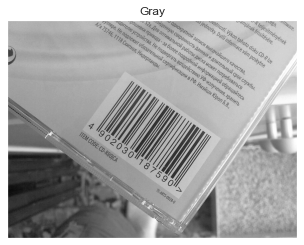

In [3]:
# Lade eines Barcode Bildes und  konvertieren  in Graustufen
image = cv2.imread("./medium_barcode_1d/BarcodeDatasets/Dataset1/05102009081.jpg")    # einlesen des Bildes
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)                                         # Konvertierung BGR-> RGB
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)                                        # Konvertierung BGR-> Grauwert

show_pic(gray, 'Gray', 'gray')

We already know that the data type of our input image would be uint8. Generally, the derivates of Black to White transitions are positive. In contrast, the White to Black transitions are negative, and hence it is highly recommended to choose a higher-order output datatype such as cv2.CV_64F and then convert the result to a uint8 type array to avoid missing any edges.

Quelle: https://www.projectpro.io/recipes/what-are-sobel-and-scharr-derivatives-opencv

### Barcodelokalisierung

https://pyimagesearch.com/2014/11/24/detecting-barcodes-images-python-opencv/

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#(_, gray)=cv2.threshold(gray, 165, 255, cv2.THRESH_BINARY)

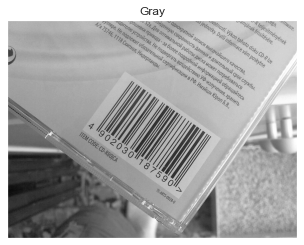

In [5]:
show_pic(gray, 'Gray', 'gray')

In [6]:
# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)

In [7]:
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

Zwischenergebnis anzeigen

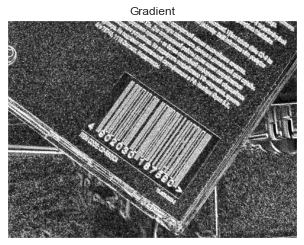

In [8]:
show_pic(gradient, 'Gradient', 'gray')

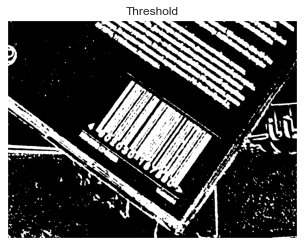

In [9]:
# blur and threshold the image
blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


show_pic(thresh, 'Threshold', 'gray')

In [10]:
# construct a closing kernel and apply it to the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

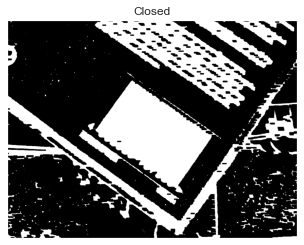

In [11]:

show_pic(closed, 'Closed', 'gray')

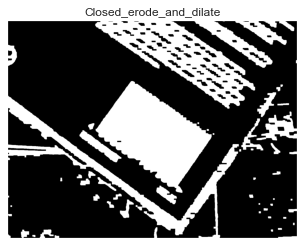

In [12]:
# perform a series of erosions and dilations
closed = cv2.erode(closed, None, iterations = 4)
closed = cv2.dilate(closed, None, iterations =4)

show_pic(closed, 'Closed_erode_and_dilate', 'gray')

In [13]:
# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# otherwise, sort the contours by area and compute the rotated
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

In [14]:
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
rect

((823.075439453125, 640.5765380859375),
 (592.9541625976562, 372.36956787109375),
 35.37184524536133)

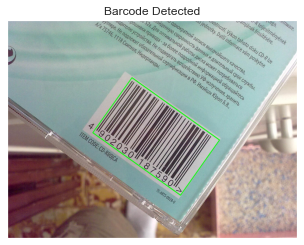

In [15]:
# draw a bounding box arounded the detected barcode and display the
# image
cv2.drawContours(image, [box], -1, (0, 255, 0), 3)
#cv2.imshow("Image", image)
show_pic(image, 'Barcode Detected')

#cv2.waitKey(0)

In [16]:
def crop_rect(rect, box, img):
     W = rect[1][0]
     H = rect[1][1]
     Xs = [i[0] for i in box]
     Ys = [i[1] for i in box]
     x1 = min(Xs)
     x2 = max(Xs)
     y1 = min(Ys)
     y2 = max(Ys)
         
     # Center of rectangle in source image
     center = ((x1+x2)/2,(y1+y2)/2)
     # Size of the upright rectangle bounding the rotated rectangle
     size = (x2-x1, y2-y1)
     # Cropped upright rectangle
     cropped = cv2.getRectSubPix(image, size, center)
        
     angle = rect[2]
     if angle!=90: #need rotation
         if angle>45:
             angle = 0 - (90 - angle)
         else:
             angle = angle
         M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
            
         cropped = cv2.warpAffine(cropped, M, size)
         croppedW = H if H > W else W
         croppedH = H if H < W else W
         # Final cropped & rotated rectangle
         croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW),int(croppedH)), (size[0]/2, size[1]/2))
         return croppedRotated
     return cropped
    

In [17]:
original_sized = cv2.resize(thresh, (image.shape[1],image.shape[0]), interpolation = cv2.INTER_AREA)
contours, hierarchy = cv2.findContours(original_sized,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    

In [18]:
rect

((823.075439453125, 640.5765380859375),
 (592.9541625976562, 372.36956787109375),
 35.37184524536133)

In [19]:
cropped = crop_rect(rect,box,original_sized)

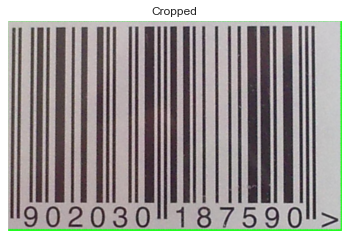

In [20]:
show_pic(cropped, 'Cropped')

candidates = []
index = 0
added_index = []
for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect) 
    box = np.int0(box)
    cropped = crop_rect(rect,box,original_sized)
    width = cropped.shape[1]
    child_index = hierarchy[0][index][2]
    #the min width of EAN13 is 95 pixel
    if width > 95:
        has_overlapped = False
        if child_index in added_index:
            has_overlapped = True
        if has_overlapped == False:
            added_index.append(index)
            candidate = {"cropped": cropped, "rect": rect}
            candidates.append(candidate)
    index =index +1

### Barcode Decode

References:
For Detection
https://www.dynamsoft.com/codepool/locating-and-decoding-ean13-python-opencv.html
For the Algorithm
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2859730/


https://softmatic.com/barcode-ean-13.html#ean-vs-upc
Check digit information:

Using the sample barcode from above, our numbers are "401234567890".

Summing up: 0 * 3 + 9 * 1 + 8 * 3 + 7 * 1 + 6 * 3 + 5 * 1 + 4 * 3 + 3 * 1 + 2 * 3 + 1 * 1 + 0 * 3 + 4 * 1 = 89
Dividing: 89 / 10 = 8 Reminder 9
Check digit: 10 - 9 = 1

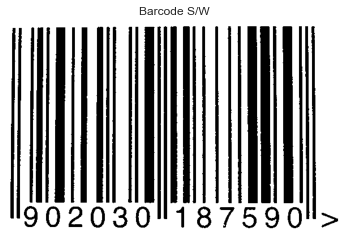

In [46]:
bar_img=cropped
bar_gray=cv2.cvtColor(bar_img, cv2.COLOR_BGR2GRAY)                                 #Konvertieren Grauwerte
ret, bar_thresh =cv2.threshold(bar_gray, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) #Konvertieren S/W
#bar_thresh=cv2.bitwise_not(bar_thresh)                                              #invertieren
show_pic(bar_thresh, 'Barcode S/W', 'gray')

### Decodieralgorithmus  

In [47]:
line=bar_thresh[int(bar_img.shape[0]/2)]       #Pixelwerte der horizontalen Mittellinie.      
#line  # Ausgabe zum checken

In [48]:
 for i in range(len(line)):
     if line[i] == 255:
         line[i] = 1
            
#line

Jede Sequenz hat eine Breite von 7*Modulus (digits) und es gibt 12 Sequenzen (84 digits)
Hinzu kommen 3 Regionen Startsequenz ( 3digits), Mittelsequenz(5 digits) und Endsequenz(3 digits)
Insgesamt sind es 95 digits / modulo
Lesen der 95 digits und Bestimmung der Modulusgröße. Die Modulegröße ist die Breite  des schmalsten Balkens (Weiß oder Schwarz)

In [49]:
def read_bars(line):                   # Funktion 
     bars = []                         # Initialisieren einer Liste "bars" zur aufnahme der Bar-Pixelbreite in Form von Nullen oder Einsen
     current_length = 1
     for i in range(len(line)-1):      # Schleife die welche den Line Array durchläuft und 
         if line[i] == line[i+1]:      # vergleich ob es ein Wechsel von Null auf Eins oder umgekehrt gab ansonsten wird der Zähler hochgesezt
             current_length = current_length + 1
         else:
             bars.append(current_length * str(line[i]))  # Hat ein Wechsel statt gefunden , wird der Liste " bars " 
                                                         #entsprechend ein Block Chars mit den gezählten Nullen oder Einsen 
                                                         # hinzugefügt
             current_length = 1                          # Zurücksetzen des Zählers
     #Entfernen des irrelevanten Abschnitts zu Beginn bis zur Startsequenz
     bars.pop(0)
     return bars

In [50]:
#read_bars(line)   # Ausgabe welche Werte von der extrhierten Pixel "line" aufgenommen wurden

In [51]:
def detect_module_size(bars):                             #Funktion 
     size = len(bars[0])                                  # Initial wird die Größe aus dem Ersten Balken der Startsequenz abgeleitet
     for bar in bars:                                     # In einer For Schleife werden alle anderen Einträge der Liste "bars" bezüglich ihrer Länge
         size = min(len(bar),size)                        # verglichen mit der Initialen Größe und übernommen wenn diese kleiner ist
     return size

module_size = detect_module_size(read_bars(line))         #Nutzung der definierten Funktionen um die Modulgröße zu ermitteln

In [52]:
module_size   #Ausgabe der Modulgröße

5

In [53]:
def array_as_string(array, module_size):
     s = ""
     for value in array:
         s = s + str(value)
     s=s.replace("1"*module_size,"1")                    #Komprimieren der Einsen entsprechend der ermittelten Modulgröße
     s=s.replace("0"*module_size,"0")                    #Komprimieren der Einsen entsprechend der ermittelten Modulgröße
     print("Data string: " + s)
     return s
        


In [54]:
data_string = array_as_string(line,module_size)

Data string: 1110011011111011000110111000001111011110001111000010011011111110010011100000110010011000111000011011110111110011111001110011110000010000011001110000011110110011011111111111


## encrypting EAN13 Code
https://www.dcode.fr/barcode-ean13

Für die Dekodierung  sind mehrere Elemente notwendig.
Eine Erste Kodiertabelle beinhaltet die Paritäten für den 6-Stellingen linken Teil ( bis zum Mitteltrenner) des Barcodes. Diese Paritäten abhängig sind von der erste Stelle des Barcodes.
Für jede Zahl 0-9 der ersten Stelle exisitiert eine 6-stellige Sequenz von gerade und ungerade, z. B.  [1,1,2,1,2,2] . In der Sequenz steht 1 für ungerade und 2 für gerade.
Basierend auf dieser Sequenz wird vorgegeben welche der zwei vorhandenen 7bit-Kodierung für die einzelnen Stellen des 6-stellingen linken Teil des Barcodes genommen werden muss. 

Für die Zahl 0 gibt es beispielsweise diee Kodierung 0001101 wenn die Parität ungerade war und
0100111 wenn diese gerade war.

Für den 6-Stellingen Part rechts der Mitteltrennung gibt es nur eine Kodierung

In [55]:
def decode_left_bar_pattern(pattern):
     left_pattern_dict = {}
     left_pattern_dict["0001101"] = {"code":0,"parity":"O"}
     left_pattern_dict["0100111"] = {"code":0,"parity":"E"}
     left_pattern_dict["0011001"] = {"code":1,"parity":"O"}
     left_pattern_dict["0110011"] = {"code":1,"parity":"E"}
     left_pattern_dict["0010011"] = {"code":2,"parity":"O"}
     left_pattern_dict["0011011"] = {"code":2,"parity":"E"}
     left_pattern_dict["0111101"] = {"code":3,"parity":"O"}
     left_pattern_dict["0100001"] = {"code":3,"parity":"E"}
     left_pattern_dict["0100011"] = {"code":4,"parity":"O"}
     left_pattern_dict["0011101"] = {"code":4,"parity":"E"}
     left_pattern_dict["0110001"] = {"code":5,"parity":"O"}
     left_pattern_dict["0111001"] = {"code":5,"parity":"E"}
     left_pattern_dict["0101111"] = {"code":6,"parity":"O"}
     left_pattern_dict["0000101"] = {"code":6,"parity":"E"}
     left_pattern_dict["0111011"] = {"code":7,"parity":"O"}
     left_pattern_dict["0010001"] = {"code":7,"parity":"E"}
     left_pattern_dict["0110111"] = {"code":8,"parity":"O"}
     left_pattern_dict["0001001"] = {"code":8,"parity":"E"}
     left_pattern_dict["0001011"] = {"code":9,"parity":"O"}
     left_pattern_dict["0010111"] = {"code":9,"parity":"E"}
     return left_pattern_dict[pattern]

In [56]:
guard_pattern = "101"
center_guard_pattern = "01010"

In [66]:
begin_index = data_string.find(guard_pattern)+len(guard_pattern)
begin_index

9

In [67]:
data_string_left = data_string[begin_index:-1]
data_string_left

'111101100011011100000111101111000111100001001101111111001001110000011001001100011100001101111011111001111100111001111000001000001100111000001111011001101111111111'

In [71]:
start_index=0
bar_pattern = data_string_left[start_index:start_index+7]
bar_pattern

'1111011'

In [72]:
decoded = decode_left_bar_pattern(bar_pattern)
decoded

KeyError: '1111011'

In [63]:
left_codes = []
for i in range(6):
     start_index = i*7
     bar_pattern = data_string_left[start_index:start_index+7]
     decoded = decode_left_bar_pattern(bar_pattern)
     left_codes.append(decoded)

KeyError: '1111011'

In [28]:
s=10

slice_H=0
slice_W=0
center_H=0
center_W=0

In [29]:
slice_W= bar_img.shape[1]
slice_H=bar_img.shape[0]/s
center_H=slice_H/2
center_W=slice_W/2

In [30]:
Barcodeslslice = cv2.getRectSubPix(bar_thresh, (int(slice_W),int(slice_H)), (center_W, center_H))

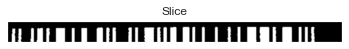

In [31]:
show_pic(Barcodeslslice, 'Slice','gray')

In [32]:
center_H=center_H + slice_H